In [2]:
import csv
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.dummy import DummyClassifier
import xgboost as xgb
import random
import zipfile
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# ====================================
# Step 1: Load Data
# ====================================
# Set the dataset name
csv_path_train = '/content/drive/MyDrive/AllergenAI-new/1280_dim_ESM-2_embeddings/algpred2_train_esm2_1280dim_embeddings.csv'
csv_path_test = '/content/drive/MyDrive/AllergenAI-new/1280_dim_ESM-2_embeddings/algpred2_test_esm2_1280dim_embeddings.csv'
# Construct embedding file paths based on dataset name
embedding_files = {
    "train": csv_path_train,
    "test": csv_path_test
}

# Load the data
df_train = pd.read_csv(embedding_files["train"])
df_test = pd.read_csv(embedding_files["test"])


feature_cols = [f"f{i}" for i in range(1280)]
X_train_full = df_train[feature_cols].values
y_train_full = df_train["label"].values

X_test = df_test[feature_cols].values
y_test = df_test["label"].values

print(f"✅ Loaded: Train={X_train_full.shape}, Test={X_test.shape}")

# ====================================
# Step 2: Dummy Classifier Baseline (on Train)
# ====================================
print("\n📉 DummyClassifier (Stratified) on Training Set (CV):\n")
dummy = DummyClassifier(strategy="stratified", random_state=42)
dummy_aucs = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in cv.split(X_train_full, y_train_full):
    dummy.fit(X_train_full[train_idx], y_train_full[train_idx])
    y_dummy_proba = dummy.predict_proba(X_train_full[val_idx])[:, 1]
    auc = roc_auc_score(y_train_full[val_idx], y_dummy_proba)
    dummy_aucs.append(auc)

print(f"📊 Dummy ROC-AUC: {np.mean(dummy_aucs):.4f} ± {np.std(dummy_aucs):.4f}")

# ====================================
# Step 3: Cross-Validation on Training Set (XGBoost)
# ====================================
print("\n🚀 5-Fold Cross-Validation (XGBoost) on Training Set...\n")
xgb_aucs = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_full, y_train_full)):
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_proba)
    xgb_aucs.append(auc)

    print(f"📂 Fold {fold+1} AUC: {auc:.4f}")
    print(classification_report(y_val, y_pred, digits=4))
    print("------")

print(f"\n✅ Mean CV ROC-AUC: {np.mean(xgb_aucs):.4f} ± {np.std(xgb_aucs):.4f}")

# ====================================
# Step 4: Final Test Set Evaluation
# ====================================
print("\n🔒 Final Evaluation on Hold-Out Test Set...\n")
clf_final = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
clf_final.fit(X_train_full, y_train_full)

y_test_pred = clf_final.predict(X_test)
y_test_proba = clf_final.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, y_test_proba)
print(classification_report(y_test, y_test_pred, digits=4))
print(f"🎯 Final Test ROC-AUC: {test_auc:.4f}")

# ====================================
# Step 5: Y-Scrambling Control
# ====================================
print("\n🧪 Y-Scrambling (sanity check) on Training Set...\n")
y_scrambled = y_train_full.copy()
random.seed(42)
random.shuffle(y_scrambled)

scrambled_aucs = []
for train_idx, val_idx in cv.split(X_train_full, y_scrambled):
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_scrambled[train_idx], y_scrambled[val_idx]

    clf_scrambled = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    clf_scrambled.fit(X_train, y_train)
    y_proba_scrambled = clf_scrambled.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_proba_scrambled)
    scrambled_aucs.append(auc)

print(f"🔀 Y-Scrambled ROC-AUC: {np.mean(scrambled_aucs):.4f} ± {np.std(scrambled_aucs):.4f}")
print("👉 This should be near 0.5 if your real model learned something.")

✅ Loaded: Train=(16120, 1280), Test=(4030, 1280)

📉 DummyClassifier (Stratified) on Training Set (CV):

📊 Dummy ROC-AUC: 0.4991 ± 0.0000

🚀 5-Fold Cross-Validation (XGBoost) on Training Set...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📂 Fold 1 AUC: 0.9973
              precision    recall  f1-score   support

           0     0.9876    0.9857    0.9867      1612
           1     0.9858    0.9876    0.9867      1612

    accuracy                         0.9867      3224
   macro avg     0.9867    0.9867    0.9867      3224
weighted avg     0.9867    0.9867    0.9867      3224

------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:45:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📂 Fold 2 AUC: 0.9978
              precision    recall  f1-score   support

           0     0.9839    0.9839    0.9839      1612
           1     0.9839    0.9839    0.9839      1612

    accuracy                         0.9839      3224
   macro avg     0.9839    0.9839    0.9839      3224
weighted avg     0.9839    0.9839    0.9839      3224

------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:46:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📂 Fold 3 AUC: 0.9987
              precision    recall  f1-score   support

           0     0.9894    0.9826    0.9860      1612
           1     0.9827    0.9895    0.9861      1612

    accuracy                         0.9860      3224
   macro avg     0.9861    0.9860    0.9860      3224
weighted avg     0.9861    0.9860    0.9860      3224

------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:47:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📂 Fold 4 AUC: 0.9982
              precision    recall  f1-score   support

           0     0.9851    0.9839    0.9845      1612
           1     0.9839    0.9851    0.9845      1612

    accuracy                         0.9845      3224
   macro avg     0.9845    0.9845    0.9845      3224
weighted avg     0.9845    0.9845    0.9845      3224

------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:48:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📂 Fold 5 AUC: 0.9984
              precision    recall  f1-score   support

           0     0.9906    0.9839    0.9872      1612
           1     0.9840    0.9907    0.9873      1612

    accuracy                         0.9873      3224
   macro avg     0.9873    0.9873    0.9873      3224
weighted avg     0.9873    0.9873    0.9873      3224

------

✅ Mean CV ROC-AUC: 0.9981 ± 0.0005

🔒 Final Evaluation on Hold-Out Test Set...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:49:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0     0.7967    0.9916    0.8835      2015
           1     0.9888    0.7469    0.8510      2015

    accuracy                         0.8692      4030
   macro avg     0.8927    0.8692    0.8672      4030
weighted avg     0.8927    0.8692    0.8672      4030

🎯 Final Test ROC-AUC: 0.9802

🧪 Y-Scrambling (sanity check) on Training Set...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:50:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:51:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:52:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:53:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

🔀 Y-Scrambled ROC-AUC: 0.4988 ± 0.0081
👉 This should be near 0.5 if your real model learned something.


In [6]:
# ====================================
# Step 1: Load Data
# ====================================
# Set the dataset name
csv_path_train = '/content/drive/MyDrive/AllergenAI-new/data/1280_dim_ESM-2_embeddings/algpred2_train_esm2_1280dim_embeddings.csv'
csv_path_test = '/content/drive/MyDrive/AllergenAI-new/data/1280_dim_ESM-2_embeddings/algpred2_test_esm2_1280dim_embeddings.csv'
# Construct embedding file paths based on dataset name
embedding_files = {
    "train": csv_path_train,
    "test": csv_path_test
}

# Load the data
df_train = pd.read_csv(embedding_files["train"])
df_test = pd.read_csv(embedding_files["test"])


feature_cols = [f"f{i}" for i in range(1280)]
X_train_full = df_train[feature_cols].values
y_train_full = df_train["label"].values

X_test = df_test[feature_cols].values
y_test = df_test["label"].values

print(f"✅ Loaded: Train={X_train_full.shape}, Test={X_test.shape}")

# ====================================
# Step 2: Dummy Classifier Baseline (on Train)
# ====================================
print("\n📉 DummyClassifier (Stratified) on Training Set (CV):\n")
dummy = DummyClassifier(strategy="stratified", random_state=42)
dummy_aucs = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in cv.split(X_train_full, y_train_full):
    dummy.fit(X_train_full[train_idx], y_train_full[train_idx])
    y_dummy_proba = dummy.predict_proba(X_train_full[val_idx])[:, 1]
    auc = roc_auc_score(y_train_full[val_idx], y_dummy_proba)
    dummy_aucs.append(auc)

print(f"📊 Dummy ROC-AUC: {np.mean(dummy_aucs):.4f} ± {np.std(dummy_aucs):.4f}")

# ====================================
# Step 3: Cross-Validation on Training Set (XGBoost)
# ====================================
print("\n🚀 5-Fold Cross-Validation (XGBoost) on Training Set...\n")
xgb_aucs = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_full, y_train_full)):
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_proba)
    xgb_aucs.append(auc)

    print(f"📂 Fold {fold+1} AUC: {auc:.4f}")
    print(classification_report(y_val, y_pred, digits=4))
    print("------")

print(f"\n✅ Mean CV ROC-AUC: {np.mean(xgb_aucs):.4f} ± {np.std(xgb_aucs):.4f}")

# ====================================
# Step 4: Final Test Set Evaluation
# ====================================
print("\n🔒 Final Evaluation on Hold-Out Test Set...\n")
clf_final = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
clf_final.fit(X_train_full, y_train_full)

y_test_pred = clf_final.predict(X_test)
y_test_proba = clf_final.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, y_test_proba)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, average="macro")
test_recall = recall_score(y_test, y_test_pred, average="macro")
test_f1 = f1_score(y_test, y_test_pred, average="macro")

print("🎯 Final Test Metrics:")
print(f"    AUC     : {test_auc:.4f}")
print(f"    Accuracy: {test_acc:.4f}")
print(f"    Precision (macro): {test_prec:.4f}")
print(f"    Recall (macro)   : {test_recall:.4f}")
print(f"    F1 Score (macro) : {test_f1:.4f}")


✅ Loaded: Train=(16120, 1280), Test=(4030, 1280)

📉 DummyClassifier (Stratified) on Training Set (CV):

📊 Dummy ROC-AUC: 0.4991 ± 0.0000

🚀 5-Fold Cross-Validation (XGBoost) on Training Set...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:40:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📂 Fold 1 AUC: 0.9973
              precision    recall  f1-score   support

           0     0.9876    0.9857    0.9867      1612
           1     0.9858    0.9876    0.9867      1612

    accuracy                         0.9867      3224
   macro avg     0.9867    0.9867    0.9867      3224
weighted avg     0.9867    0.9867    0.9867      3224

------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:40:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📂 Fold 2 AUC: 0.9978
              precision    recall  f1-score   support

           0     0.9839    0.9839    0.9839      1612
           1     0.9839    0.9839    0.9839      1612

    accuracy                         0.9839      3224
   macro avg     0.9839    0.9839    0.9839      3224
weighted avg     0.9839    0.9839    0.9839      3224

------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📂 Fold 3 AUC: 0.9987
              precision    recall  f1-score   support

           0     0.9894    0.9826    0.9860      1612
           1     0.9827    0.9895    0.9861      1612

    accuracy                         0.9860      3224
   macro avg     0.9861    0.9860    0.9860      3224
weighted avg     0.9861    0.9860    0.9860      3224

------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:42:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📂 Fold 4 AUC: 0.9982
              precision    recall  f1-score   support

           0     0.9851    0.9839    0.9845      1612
           1     0.9839    0.9851    0.9845      1612

    accuracy                         0.9845      3224
   macro avg     0.9845    0.9845    0.9845      3224
weighted avg     0.9845    0.9845    0.9845      3224

------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:42:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📂 Fold 5 AUC: 0.9984
              precision    recall  f1-score   support

           0     0.9906    0.9839    0.9872      1612
           1     0.9840    0.9907    0.9873      1612

    accuracy                         0.9873      3224
   macro avg     0.9873    0.9873    0.9873      3224
weighted avg     0.9873    0.9873    0.9873      3224

------

✅ Mean CV ROC-AUC: 0.9981 ± 0.0005

🔒 Final Evaluation on Hold-Out Test Set...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:43:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🎯 Final Test Metrics:
    AUC     : 0.9802
    Accuracy: 0.8692
    Precision (macro): 0.8927
    Recall (macro)   : 0.8692
    F1 Score (macro) : 0.8672



🔥 SHAP Analysis...



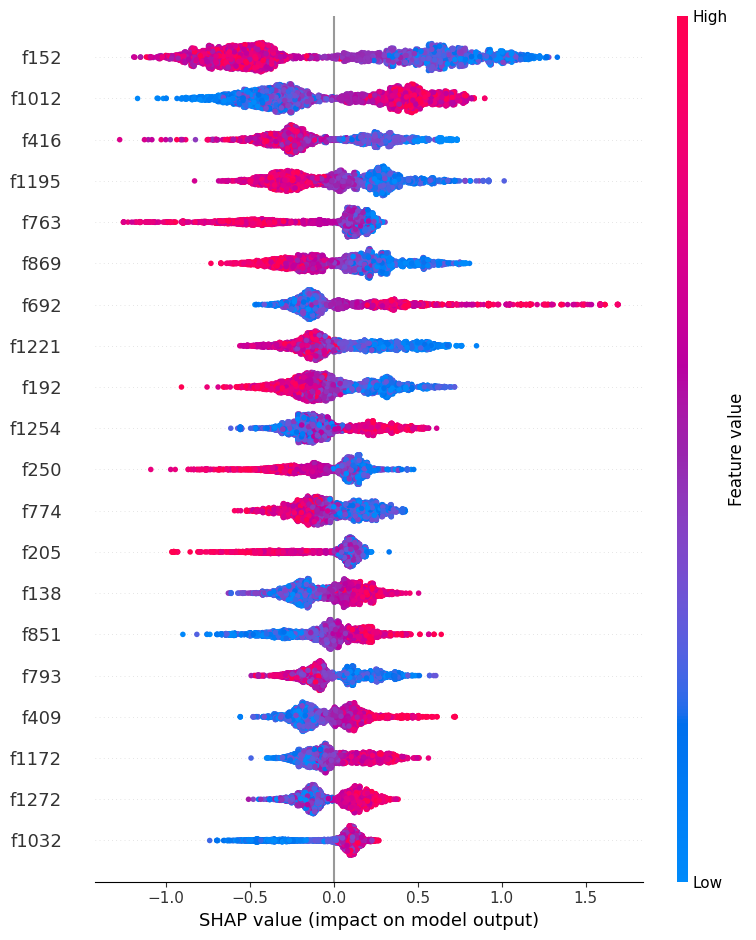

In [ ]:
import shap

# ====================================
# Step 🔥: SHAP Analysis
# ====================================
print("\n🔥 SHAP Analysis...\n")

# Create a SHAP explainer
explainer = shap.TreeExplainer(clf_final)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)



🧩 Confusion Matrix...



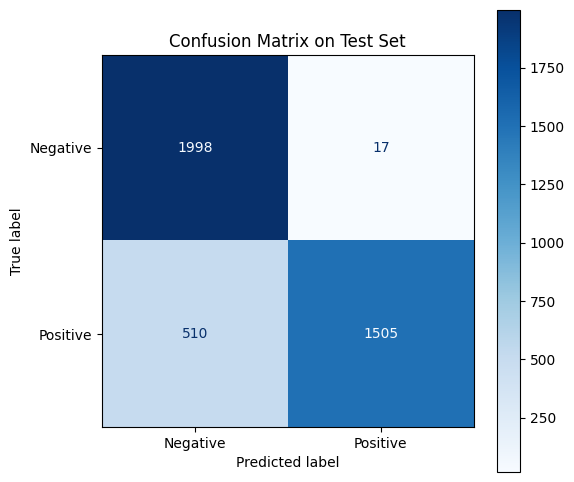

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ====================================
# Step Y: Confusion Matrix
# ====================================
print("\n🧩 Confusion Matrix...\n")

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()



🎯 Calibration Curve...



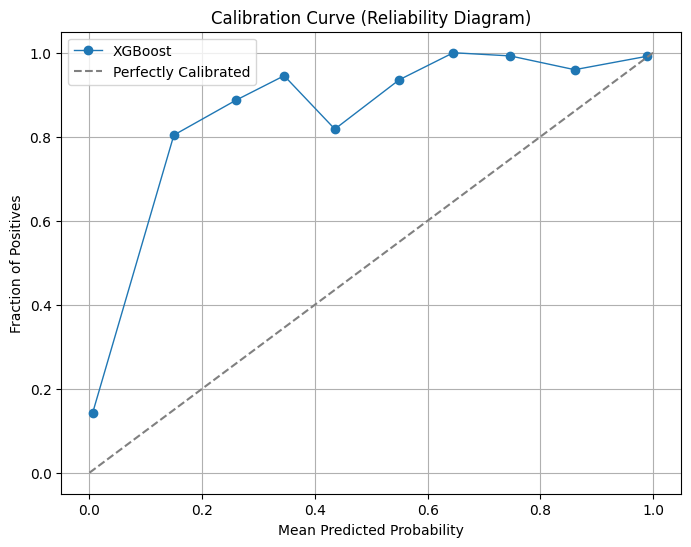

In [ ]:
from sklearn.calibration import calibration_curve

# ====================================
# Step Z: Calibration Curve
# ====================================
print("\n🎯 Calibration Curve...\n")

prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=10, strategy='uniform')

plt.figure(figsize=(8,6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='XGBoost')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.title('Calibration Curve (Reliability Diagram)')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.grid(True)
plt.show()



⭐ Feature Importance Plot...



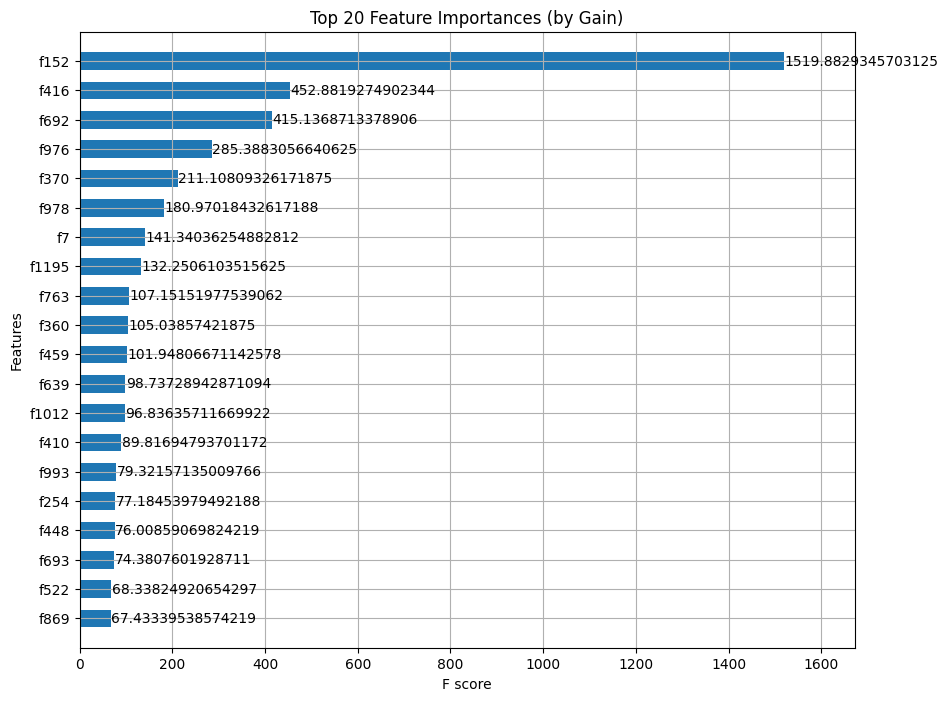

In [ ]:
# ====================================
# Step W: Feature Importance
# ====================================
print("\n⭐ Feature Importance Plot...\n")

fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(clf_final,
                    max_num_features=20,    # Top 20 important features
                    importance_type='gain', # 'gain' is usually better than 'weight'
                    height=0.6,
                    ax=ax)
plt.title('Top 20 Feature Importances (by Gain)')
plt.grid(True)
plt.show()
